Importing libraries

In [1]:
import os
import cv2
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns


from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import shuffle

from keras import Sequential, Input, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Dropout

import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def walk_through_dir(filepath):
    for dirpath, dirnames, filenames in os.walk(filepath):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    print()

def get_filetypes(filepath):
    exts = set(os.path.splitext(f)[1] for dir,dirs,files in os.walk(filepath) for f in files)
    print("File extentions on image directory: ", exts)
    return exts

def process_img(filepath):
    filenames = list(Path(filepath).glob(r'**/*{}'.format('jpg')))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filenames))

    filepaths = pd.Series(filenames, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df.sample(frac=1)


In [4]:
cali_train_path = '/content/drive/MyDrive/aisd-data/California/train'
cali_test_path = '/content/drive/MyDrive/aisd-data/California/test'
cali_val_path = '/content/drive/MyDrive/aisd-data/California/valid'

cali_train_df = process_img(cali_train_path)
print(cali_train_df.head(1))
cali_val_df = process_img(cali_val_path)
cali_test_df = process_img(cali_test_path)

                                               Filepath       Label
1014  /content/drive/MyDrive/aisd-data/California/tr...  nowildfire


In [5]:
canada_test_path = '/content/drive/MyDrive/aisd-data/Canada/test'
canada_test_df1 = process_img(canada_test_path)

In [6]:
def show_image_sample(df, num_images=16):
    selected_data = df.head(num_images)
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(selected_data.iloc[i].Filepath))
        ax.set_title(selected_data.iloc[i].Label)
    plt.tight_layout()
    plt.show()

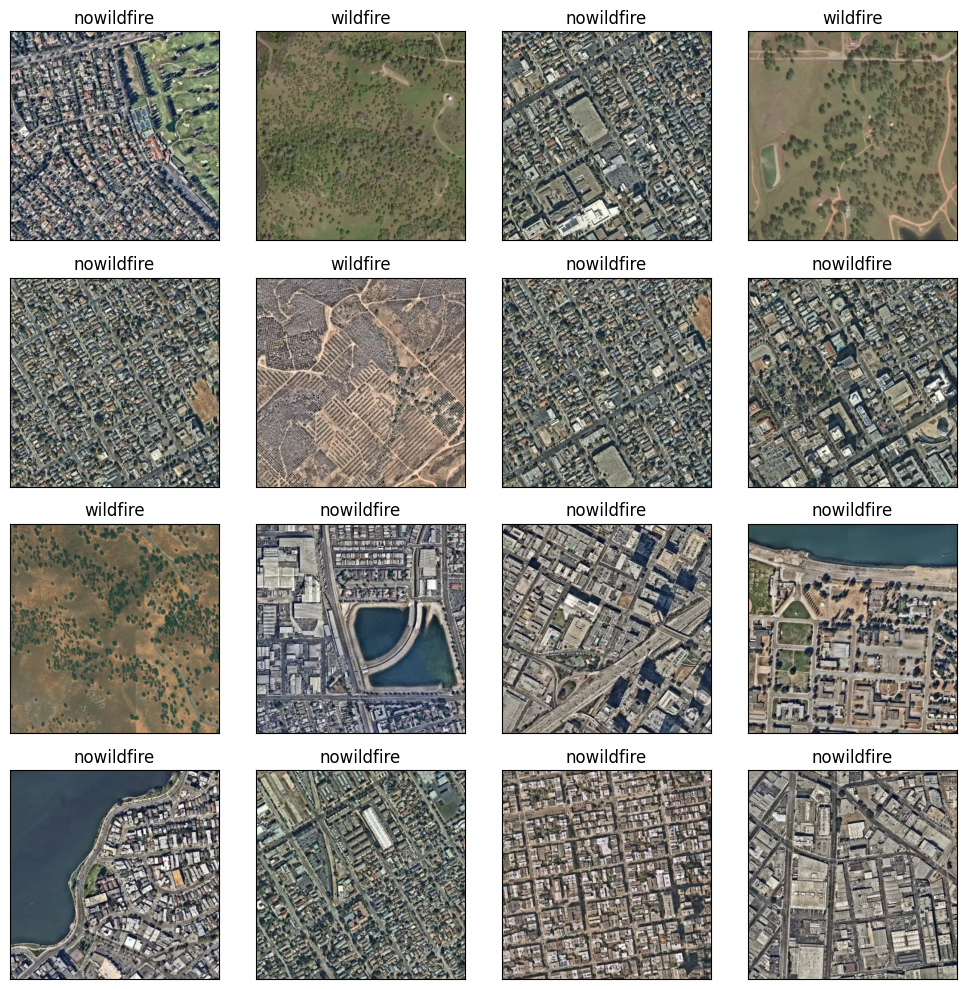

In [7]:
show_image_sample(cali_train_df)

In [8]:
import cv2
import pandas as pd
from tqdm import tqdm
from skimage import exposure

def atmospheric_correction(image):
    R, G, B = cv2.split(image)
    equalized_R = exposure.equalize_hist(R)
    equalized_G = exposure.equalize_hist(G)
    equalized_B = exposure.equalize_hist(B)
    equalized_image = cv2.merge([equalized_R, equalized_G, equalized_B])
    return equalized_image

def preprocess_dataframe(df):
    processed_images = []
    for filepath in tqdm(df['Filepath'], desc='Processing Images', unit='image'):
        image = cv2.imread(str(filepath), cv2.IMREAD_COLOR)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        corrected_image = atmospheric_correction(image_rgb)
        processed_images.append(corrected_image)
    processed_df = pd.DataFrame({
        'Processed_Image': processed_images,
        'Label': df['Label']  
    })
    return processed_df


In [9]:
canada_test_df=canada_test_df1.sample(frac=0.07,random_state=1)

In [10]:
canada_test_processed_df = preprocess_dataframe(canada_test_df)

Processing Images: 100%|██████████| 441/441 [01:24<00:00,  5.21image/s]


In [11]:
cali_train_processed_df = preprocess_dataframe(cali_train_df)

Processing Images: 100%|██████████| 1993/1993 [04:59<00:00,  6.66image/s]


In [12]:
cali_val_processed_df = preprocess_dataframe(cali_val_df)

Processing Images: 100%|██████████| 429/429 [01:49<00:00,  3.91image/s]


In [13]:
cali_test_processed_df = preprocess_dataframe(cali_test_df)

Processing Images: 100%|██████████| 429/429 [01:48<00:00,  3.96image/s]


In [14]:
def show_processed_image_sample(df, num_images=16):
    selected_data = df.head(num_images)
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        image = selected_data.iloc[i]['Processed_Image']

        ax.imshow(image)
        ax.set_title("Image "+str(i))
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd

class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.dataframe.iloc[idx]['Processed_Image'].astype(np.float32)
        label = self.dataframe.iloc[idx]['Label']
        label = 1 if label == 'wildfire' else 0

        if self.transform:
            image = self.transform(image)

        return image, label

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.ToTensor(),
])

train_dataset = ImageDataset(cali_train_processed_df, transform=val_transform)
val_dataset = ImageDataset(cali_val_processed_df, transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

alexnet = models.alexnet(pretrained=True)
alexnet.classifier[6] = nn.Linear(4096, 2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.parameters(), lr=0.00001, weight_decay=1e-5)

best_val_loss = float('inf')
patience = 5
patience_counter = 0

num_epochs = 50  
for epoch in range(num_epochs):
    alexnet.train()
    for images, labels in train_loader:
        outputs = alexnet(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    alexnet.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = alexnet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(alexnet.state_dict(), 'best_model.pth')  # Save the best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

alexnet.load_state_dict(torch.load('best_model.pth'))

torch.save(alexnet, 'alexnet_full_model.pth')

torch.save(alexnet.state_dict(), 'alexnet_state_dict.pth')

Epoch [1/50], Loss: 0.5495, Val Loss: 0.6243
Epoch [2/50], Loss: 0.4785, Val Loss: 0.5564
Epoch [3/50], Loss: 0.4244, Val Loss: 0.5030
Epoch [4/50], Loss: 0.3815, Val Loss: 0.4600
Epoch [5/50], Loss: 0.3466, Val Loss: 0.4248
Epoch [6/50], Loss: 0.3171, Val Loss: 0.3953
Epoch [7/50], Loss: 0.2703, Val Loss: 0.3494
Epoch [8/50], Loss: 0.2703, Val Loss: 0.3494
Epoch [9/50], Loss: 0.2512, Val Loss: 0.3317
Epoch [10/50], Loss: 0.2346, Val Loss: 0.3162
Epoch [11/50], Loss: 0.2193, Val Loss: 0.3031
Epoch [12/50], Loss: 0.2065, Val Loss: 0.2921
Epoch [13/50], Loss: 0.1946, Val Loss: 0.2825
Epoch [14/50], Loss: 0.1842, Val Loss: 0.2740
Epoch [15/50], Loss: 0.1754, Val Loss: 0.2665
Epoch [16/50], Loss: 0.1668, Val Loss: 0.2600
Epoch [17/50], Loss: 0.1591, Val Loss: 0.2544
Epoch [18/50], Loss: 0.1523, Val Loss: 0.2494
Epoch [19/50], Loss: 0.1460, Val Loss: 0.2449
Epoch [20/50], Loss: 0.1404, Val Loss: 0.2410
Epoch [21/50], Loss: 0.1356, Val Loss: 0.2375
Epoch [22/50], Loss: 0.1307, Val Loss: 0.23

In [16]:
loss = [0.5495, 0.4785, 0.4244, 0.3815, 0.3466, 0.3171, 0.2703, 0.2703, 0.2512, 0.2346, 0.2193,
 0.2065, 0.1946, 0.1842, 0.1754, 0.1668, 0.1591, 0.1523, 0.146, 0.1404, 0.1356, 0.1307,
 0.1263, 0.1223, 0.1185, 0.1149, 0.1118, 0.1087, 0.1061, 0.1036, 0.1013, 0.09877985,
 0.09632239, 0.09392607, 0.09158937, 0.0893108, 0.08708891, 0.08492231, 0.0828096,
 0.08074945, 0.07874056, 0.07678164, 0.07487146, 0.0730088, 0.07119248, 0.06942134,
 0.06769427, 0.06601017, 0.06436796, 0.0627666]
val_loss = [0.6243, 0.5564, 0.503, 0.46, 0.4248, 0.3953, 0.3494, 0.3494, 0.3317, 0.3162, 0.3031,
 0.2921, 0.2825, 0.274, 0.2665, 0.26, 0.2544, 0.2494, 0.2449, 0.241, 0.2375, 0.2343,
 0.2314, 0.2288, 0.2264, 0.2242, 0.2222, 0.2204, 0.2187, 0.2171, 0.2156, 0.21392005,
 0.21225319, 0.21059932, 0.20895833, 0.20733013, 0.20571462, 0.2041117, 0.20252127,
 0.20094323, 0.19937748, 0.19782394, 0.1962825, 0.19475307, 0.19323556, 0.19172987,
 0.19023592, 0.1887536, 0.18728284, 0.18582353]


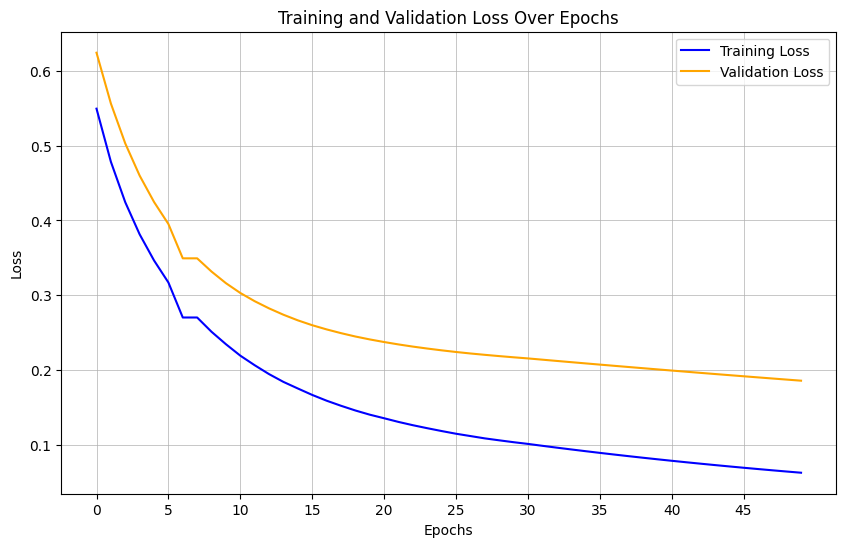

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(linestyle='-', linewidth=0.5)
plt.xticks(range(0, 50, 5)) 
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader

def evaluate_model(model, dataloader):
    model.eval()

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels)
            all_preds.extend(predicted)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')

    return accuracy, precision, recall, f1

alexnet.load_state_dict(torch.load('best_model.pth'))

accuracy, precision, recall, f1 = evaluate_model(alexnet, val_loader)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.9068
Precision: 0.8967
Recall: 0.9167
F1-Score: 0.9066


In [19]:
# Test on CALI
test_dataset = ImageDataset(cali_test_processed_df, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

accuracy, precision, recall, f1 = evaluate_model(alexnet, test_loader)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.9096
Precision: 0.9143
Recall: 0.8989
F1-Score: 0.8947


In [20]:
# Test on CANADA
test_dataset = ImageDataset(canada_test_processed_df, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

accuracy, precision, recall, f1 = evaluate_model(alexnet, test_loader)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.7968
Precision: 0.7573
Recall: 0.9679
F1-Score: 0.8498
